# LSTM Text Classification vs. TF-IDF + Logistic Regression

In this notebook, we compare two different approaches to text classification:

1. **Logistic Regression** on top of TF-IDF features
2. **LSTM** (using Keras) trained end-to-end

We'll explore:
- The architectures for each approach
- Their respective training processes
- Visualization of results and metrics
- How each model interprets words in the final decision
- Potential improvements for the LSTM model


## 1. Environment Setup & Imports

We'll install any dependencies (if needed) and import the necessary libraries.

In [1]:
# !pip install scikit-learn tensorflow keras matplotlib seaborn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)

## 2. Data Loading & Preprocessing

For demonstration, we'll assume we have a text classification dataset named `df`. It contains two columns:
- `text` : The text field
- `label`: The target label (0 or 1, for binary classification, or more classes)

We'll split the data into **train** and **test** sets, then further create a small dev set if needed.

In [2]:
# Placeholder: load your data here.
# For demonstration, let's create a small synthetic dataset.

# Load the imdb
dataset = load_dataset('imdb')
print(dataset)


# Convert to pandas DataFrame for easier manipulation
train_df = dataset['train'].shuffle(seed=42).to_pandas()
test_df = dataset['test'].shuffle(seed=42).to_pandas()
# Clean the memory
del dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


## 3. TF-IDF + Logistic Regression

We'll:
1. Vectorize our text using TF-IDF.
2. Train a Logistic Regression model.
3. Evaluate on the test set.
4. Visualize results.


In [3]:
# 3.1 Vectorize text with TF-IDF
tfidf_vec = TfidfVectorizer(stop_words='english', min_df=5, max_features=20000)

X_train_tfidf = tfidf_vec.fit_transform(train_df['text'])
y_train = train_df['label'].values

X_test_tfidf = tfidf_vec.transform(test_df['text'])
y_test = test_df['label'].values

print("X_train shape:", X_train_tfidf.shape, ", y_train shape:", y_train.shape)

X_train shape: (25000, 20000) , y_train shape: (25000,)


In [4]:
# 3.2 Train a Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

# Evaluate on test
y_pred_logreg = logreg.predict(X_test_tfidf)

print("LogisticRegression Test Classification Report:")
print(classification_report(y_test, y_pred_logreg))
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:", cm_logreg)

LogisticRegression Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Confusion Matrix: [[10979  1521]
 [ 1495 11005]]


### Visualization of Confusion Matrix

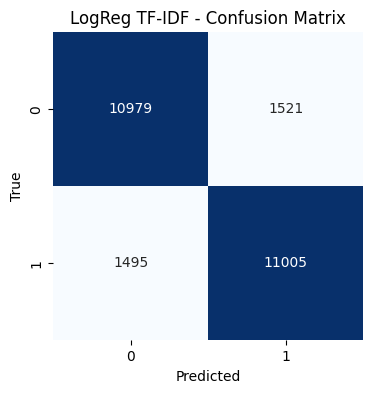

In [5]:
plt.figure(figsize=(4,4))
sns.heatmap(cm_logreg, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title("LogReg TF-IDF - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 4: LSTM Classification

In this part, we'll train a **Recurrent Neural Network (RNN)** using an **LSTM (Long Short-Term Memory)** layer — a powerful deep learning technique especially designed for **sequential data** like text.

### 🤔 Why Not Use TF-IDF for LSTMs?

TF-IDF transforms text into **fixed-length sparse vectors**, measuring the importance of each word. However, it **ignores word order**, which is crucial for understanding meaning in context.

> For example:
> - `"the cat sat on the mat"` and `"mat sat the on cat the"` will result in the **same TF-IDF vector**.

This is a problem for models like LSTMs that are built to:
- Process **sequences of words**, not unordered bags.
- Learn **how word meanings evolve across time**.
- Use **positional and contextual dependencies** to understand sentences.

### ✅ What Do LSTMs Expect as Input?

Instead of a TF-IDF vector, LSTMs take in:
- A **sequence of word IDs** (tokenized text),
- Which are then **mapped to dense vectors** (embeddings),
- And passed through the LSTM layer, which learns from the word order and meaning.

### 4.1 Preprocessing the Text for LSTM

#### Step 1️⃣ — Tokenize Text using `Tokenizer`

- The `Tokenizer` assigns a **unique ID to each word** in the training data.
- We use:
  - `num_words=vocab_size` to limit to top N most frequent words.
  - `oov_token="<OOV>"` to represent unknown or rare words.
  - `fit_on_texts(...)` to build the internal word-to-index dictionary.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
max_len = 64

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

#### Step 2️⃣ — Convert Sentences to Sequences

Each sentence is turned into a sequence of word IDs:

> `"There is no relation at all between Fortier..."`  
> becomes  
> `[48, 7, 55, 1, 31, 30, 198, 1, ...]`

- `<OOV>` is inserted for words not in the vocabulary.
- These sequences now preserve the **order of words**, which is key for LSTM models.


In [7]:
seqs = tokenizer.texts_to_sequences(train_df['text'])
print(seqs[0])
print(tokenizer.sequences_to_texts([seqs[0]]))
print(train_df['text'][0])

[48, 7, 55, 1, 31, 30, 198, 1, 3, 1, 19, 2, 190, 13, 197, 24, 566, 199, 42, 1, 1, 1, 270, 1, 1, 270, 354, 1, 1, 24, 177, 604, 1, 112, 24, 228, 51, 1, 1, 270, 51, 38, 1, 1, 45, 73, 26, 6, 1, 1, 2, 291, 107, 7, 813, 3, 1, 19, 26, 1, 82, 38, 6, 1, 6, 1, 6, 1, 87, 42, 41, 1, 161, 152, 97, 82, 485, 1, 270, 296, 19, 21, 2, 83, 506, 1, 34, 1, 296, 199, 277, 43, 2, 1, 40, 2, 1, 19, 11, 102, 12, 199, 7, 51, 629, 72, 296, 32, 2, 94, 2, 154, 24, 64, 50, 3, 161, 2, 114, 7, 22, 1, 31, 30]
["there is no <OOV> at all between <OOV> and <OOV> but the fact that both are police series about <OOV> <OOV> <OOV> looks <OOV> <OOV> looks classic <OOV> <OOV> are quite simple <OOV> plot are far more <OOV> <OOV> looks more like <OOV> <OOV> if we have to <OOV> <OOV> the main character is weak and <OOV> but have <OOV> people like to <OOV> to <OOV> to <OOV> how about just <OOV> funny thing too people writing <OOV> looks american but on the other hand <OOV> they <OOV> american series maybe it's the <OOV> or the <OOV>

#### Step 3️⃣ — Pad Sequences to Equal Length

Neural networks require inputs of consistent size. But:
- Some sentences are short, others are long.
- So we **truncate longer ones** and **pad shorter ones** to a fixed length.

We use:
- `max_len = 64`
- `pad_sequences(..., padding='post', truncating='post')`  
  to ensure all sequences are the same length, with padding (0s) added **at the end**.


In [8]:
seqs_padded = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

#### Step 4️⃣ — Split into `X` and `y`

At this point, we have:
- `X_train_seq`: Padded sequences of token IDs.
- `y_train_lstm`: Corresponding binary labels (0 or 1).

The same applies for the test set: `X_test_seq`, `y_test_lstm`.

### ✏️ Note on Using the Same Vocabulary for LSTM and TF-IDF

To ensure a fair comparison between the Logistic Regression (TF-IDF) and LSTM models:
- We use the **same vocabulary** from the TF-IDF vectorizer.
- This means we ignore stopwords and low-frequency words **consistently**.
- The only addition is the `<OOV>` token used by LSTM to handle unknowns.

In [9]:
#Create the tokenizer with the same vocabulary as the TF-IDF vectorizer
custom_vocab = tfidf_vec.vocabulary_
vocab_size = len(custom_vocab) + 1 # +1 for the OOV token
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Manually assign word index
tokenizer.word_index = {word: i for i, word in enumerate(custom_vocab)}
tokenizer.word_index[tokenizer.oov_token] = len(custom_vocab)
print(len(tokenizer.word_index))

#DO NOT fit the tokenizer on the training data otherwise you will have a mismatch between the tokenizer and the TF-IDF vectorizer

##Let's increase the max length of the sequences to 128
max_len = 128

# Let's create a function to convert the text to a sequence of token IDs and pad them to the same length: 128

def text_to_seq(df_col, max_len=128):
    seqs = tokenizer.texts_to_sequences(df_col)
    # pad
    seqs_padded = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')
    return seqs_padded

X_train_seq = text_to_seq(train_df['text'].map(lambda x: x.lower()), max_len=max_len)
X_test_seq = text_to_seq(test_df['text'].map(lambda x: x.lower()), max_len=max_len)

y_train_lstm = train_df['label'].values
y_test_lstm  = test_df['label'].values

print(train_df['text'][0].split()[:max_len])
print(X_train_seq[0])
print(y_train_lstm[0])

X_train_seq.shape, y_train_lstm.shape

20001
['There', 'is', 'no', 'relation', 'at', 'all', 'between', 'Fortier', 'and', 'Profiler', 'but', 'the', 'fact', 'that', 'both', 'are', 'police', 'series', 'about', 'violent', 'crimes.', 'Profiler', 'looks', 'crispy,', 'Fortier', 'looks', 'classic.', 'Profiler', 'plots', 'are', 'quite', 'simple.', "Fortier's", 'plot', 'are', 'far', 'more', 'complicated...', 'Fortier', 'looks', 'more', 'like', 'Prime', 'Suspect,', 'if', 'we', 'have', 'to', 'spot', 'similarities...', 'The', 'main', 'character', 'is', 'weak', 'and', 'weirdo,', 'but', 'have', '"clairvoyance".', 'People', 'like', 'to', 'compare,', 'to', 'judge,', 'to', 'evaluate.', 'How', 'about', 'just', 'enjoying?', 'Funny', 'thing', 'too,', 'people', 'writing', 'Fortier', 'looks', 'American', 'but,', 'on', 'the', 'other', 'hand,', 'arguing', 'they', 'prefer', 'American', 'series', '(!!!).', 'Maybe', "it's", 'the', 'language,', 'or', 'the', 'spirit,', 'but', 'I', 'think', 'this', 'series', 'is', 'more', 'English', 'than', 'American.', 

((25000, 128), (25000,))

### Embeddings: the input of the LSTM

The LSTM (or RNNs) is fed with the tokenized sequences of the reviews. Nevertheless, if we feed the RNN with the raw token IDs (represented as integers above) the RNN will be just get as inputs the positions of the words in the vocabulary nothing more. To gain more information we use **the embeddings**.

Let's first link embeddings to the TF-IDF pipeline.

#### 🧠 Embeddings in the TF-IDF Pipeline

In the TF-IDF + logistic regression model, the model learned the embeddings implicitly from the TF-IDF vectorizer. The embeddings are learned when we fit the vectorizer to the training data. In the end we associate, for each sentence, each word to a weight and the sentence is represented as a vector of the weights. We say that we have a "sentence embedding". 

In a TF-IDF + Logistic Regression model:
- Each word is assigned **a single numerical weight**.
- This weight reflects how important the word is in the review.
- The model uses this fixed value as the representation of the word.
- The logistic regression model uses the sentence embedding to make the prediction.

See below:

In [10]:
# let's look at the first review in the training set
# and see the TF-IDF vector where we have the weights for each word
# and look at weights > 0

print('TF-IDF vector for the first review in the training set:')
print(tfidf_vec.transform(train_df['text'][:1]).toarray())

print('\nTF-IDF vector for the first review in the training set where we have the weights for each word:')
non_zero_indices = np.where(tfidf_vec.transform(train_df['text'][:1]).toarray() > 0)[1]
for index in non_zero_indices[:10]:
    print(f"{tfidf_vec.get_feature_names_out()[index]}, {index} -> {tfidf_vec.transform(train_df['text'][:1]).toarray()[0, index]}")

print('\nTF-IDF vector for the first review in the training set where we have the weights for each word:')
print(tfidf_vec.transform(train_df['text'][:1]).toarray()[0, non_zero_indices])

TF-IDF vector for the first review in the training set:
[[0. 0. 0. ... 0. 0. 0.]]

TF-IDF vector for the first review in the training set where we have the weights for each word:
acting, 411 -> 0.06453486881043621
actors, 422 -> 0.07451506986747358
american, 798 -> 0.282849599154727
arguing, 1097 -> 0.18188205992788842
character, 3121 -> 0.06712120649061068
clairvoyance, 3387 -> 0.22993873098246653
classic, 3407 -> 0.09600506078617589
compare, 3741 -> 0.13682793832789433
complicated, 3788 -> 0.15271278591080203
crimes, 4363 -> 0.16069252150549165

TF-IDF vector for the first review in the training set where we have the weights for each word:
[0.06453487 0.07451507 0.2828496  0.18188206 0.06712121 0.22993873
 0.09600506 0.13682794 0.15271279 0.16069252 0.1132163  0.15364272
 0.20665086 0.07954201 0.08338438 0.15625659 0.04963082 0.10494199
 0.14360214 0.04733146 0.12566851 0.08952358 0.35838411 0.09075236
 0.08986416 0.12151923 0.06613852 0.14117013 0.11334531 0.15152355
 0.14943343 0.0

Nevertheless, those weights don’t capture relationships between words. They are learned from the data and are fixed for each word. We basically put all the information of one word in a single number. The semantic meaning is limited.

#### 🧠 Embeddings in the LSTM Pipeline

As we said, the LSTM could be fed with the tokenized sequences of the reviews: their positions in the vocabulary. To gain *word importance and semantic* we can add a layer between the tokenized sequences and the LSTM cells. This layer is called the **embedding layer**.

This embedding layer is the matrix of weights. In the case of the TF-IDF pipeline it would be the matrix of the weights of the words in the vocabulary. A matrix with one column and as many rows as the number of words in the vocabulary.

As we said, one value is quite limited to capture the semantic meaning of a word. So we use a dense vector to represent a word instead of a single number.

Therefore, in an LSTM pipeline:
- We tokenize the sentences and have a sequence of token IDs which represent the words in the sentences.
- Each word is mapped to a **dense vector** (e.g. `[0.21, -0.67, 0.04, ...]`) instead of a single number.
- We feed the LSTM with the sequence of dense vectors instead of the token IDs.

Therefore when we set up the LSTM pipeline we need to set up the embedding layer at first. We can see the embedding layer as a matrix of weights for the whole vocabulary. And one vector is associated to one word. This vector will be the **word embedding** said differently the vector carries the semantic meaning of the word.

We will dive more into embeddings in the next session.

#### More concretely

In the LSTM pipeline, we add a layer, called the **embedding layer**, which turns each token ID into a **dense vector** — like turning `actor` into `[0.21, -0.67, 0.04, ...]`. This dense vector for `actor`is part of the vocabulary matrix.

Each word of the sequence is mapped to a dense vector, we feed the LSTM with the sequence and then we add classifier, concretely a dense layer with a sigmoid activation function.

When we train the whole pipeline, we will train also the embedding layer.

📌 Without embeddings, LSTM would be just memorizing token positions — embeddings help it understand **meaning** of the words.


## ✅ Summary

| Feature                | TF-IDF + Logistic Regression     | Tokenized Sequence + LSTM               |
|------------------------|----------------------------------|------------------------------------------|
| Input Format           | Sparse fixed-length vector       | Sequence of token IDs                   |
| Captures Word Order?   | ❌ No                            | ✅ Yes                                  |
| Learns Contextual Meaning | ❌ No                        | ✅ Yes (via Embeddings)                 |
| Model Complexity       | Simpler, interpretable           | More expressive, less interpretable     |
| Good For               | Quick baselines                  | Sequence modeling, complex patterns     |


Using **embedding + LSTM** lets us build **context-aware models** that understand **both word meanings and their positions**, which is essential for tasks like **sentiment analysis**, **text generation**, and **sequence classification**.

### 4.2 Build the LSTM Model

Now that we have our sequences ready and padded, we can build an LSTM-based neural network using Keras.

We’ll use a simple architecture:
- An **Embedding layer** to learn word representations.
- A single **LSTM layer** to process the sequence.
- A **Dense layer** with a sigmoid activation to output binary predictions.

Let’s break this down:

- `Embedding(input_dim, output_dim)`: This layer takes each word ID and maps it to a dense vector. Here, `input_dim` is the vocabulary size, and `output_dim` is the size of the embedding (we use 16).
- `LSTM(units)`: Processes the sequence of embeddings, capturing patterns and dependencies across time.
- `Bidirectional(LSTM(units))`: This layer processes the sequence in both directions (forward and backward), capturing patterns and dependencies across time.
- `Flatten()`: This layer flattens the output of the LTSM layer into a 1D vector. As we asked the LSTM to return the sequences we need to flatten the output to have a 1D vector and have the information of the whole sequence.
- `Dense(1, activation='sigmoid')`: Outputs a single probability for binary classification (positive or negative label).

The optimizer is Adam with a learning rate of 0.01.

In [11]:
embedding_dim = 16
# The input is a sequence of integers of length max_len (128)
inputs = keras.Input(shape=(max_len,), dtype="int32")
# Embed each integer in a 16-dimensional vector
x = layers.Embedding(vocab_size, embedding_dim)(inputs)
# Add bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 16)        │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 64)        │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,753 (1.30 MB)

 Trainable params: 340,753 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Train the LSTM Model

Now we train the model using our preprocessed sequences and binary labels.

We use:
- `validation_split=0.2`: to hold out 20% of training data for validation.
- `epochs=10`: to iterate 10 times over the dataset.
- `batch_size=128`: A high batch size to speed up training and also to reduce overfitting.

Note that LSTMs are more computationally expensive than logistic regression, so training can take longer — especially with small batches. 

To control the overfitting we can use the callback `EarlyStopping` to stop the training if the validation loss does not improve for 3 epochs.

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', 'recall', 'precision']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train_seq, y_train_lstm,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5588 - loss: 0.6901 - precision: 0.5706 - recall: 0.4375 - val_accuracy: 0.7020 - val_loss: 0.5479 - val_precision: 0.6357 - val_recall: 0.9717
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8026 - loss: 0.4260 - precision: 0.7837 - recall: 0.8272 - val_accuracy: 0.8424 - val_loss: 0.3636 - val_precision: 0.8712 - val_recall: 0.8103
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9045 - loss: 0.2484 - precision: 0.8973 - recall: 0.9110 - val_accuracy: 0.8550 - val_loss: 0.3502 - val_precision: 0.8479 - val_recall: 0.8716
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9407 - loss: 0.1600 - precision: 0.9370 - recall: 0.9450 - val_accuracy: 0.8368 - val_loss: 0.4265 - val_precision: 0.8314 - val_recall: 0.8523
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9700 - loss: 0.0837 - precision: 0.9673 - recall: 0.9729 - val_accuracy: 0.8358 - va

### 4.4 Training Curves
Let's visualize the training and validation accuracy/loss.

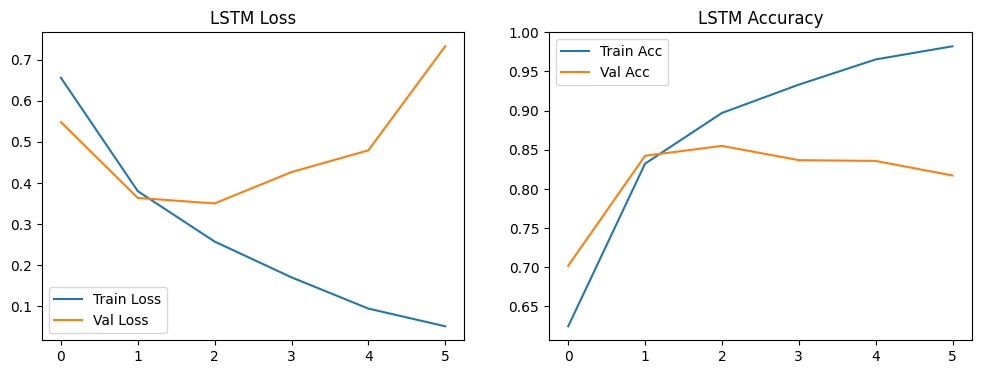

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('LSTM Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()

In [15]:
y_pred_lstm_prob = model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm_prob>0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     12500
           1       0.83      0.70      0.76     12500

    accuracy                           0.78     25000
   macro avg       0.79      0.78      0.78     25000
weighted avg       0.79      0.78      0.78     25000



Okay that's interesting. We see that the validation loss is decreasing more or less till epoch 3 and then it starts to increase. This is a sign of overfitting. Plus the validation accuracy is quite stable or slightly decreasing after the same number of epochs. We can try to reduce the overfitting by using regularization or dropout. We even see that the results are bad at the end of the training.

Ans we see that the results are not so good (at least worst than the logistic regression with TF-IDF). 78% of accuracy is not so good compared to the 88% of the logistic regression with TF-IDF. The overfitting may be one reason. Let's try to reduce the overfitting.

### ⚖️ Regularization 

Regularization is a technique used to prevent overfitting. It adds a penalty term to the loss function that encourages the model to have smaller weights. This helps prevent the model from fitting the noise in the training data.

We can use L2 regularization or L1 regularization.

Concretely we can add the regularization to the LSTM layer or the dense layer with `activity_regularizer=keras.regularizers.l2(0.01)` or `activity_regularizer=keras.regularizers.l1(0.01)`.

### 🕳️ Dropout

Dropout is a technique used to prevent overfitting. It randomly drops out some neurons in the network during training. This helps prevent the model from fitting the noise in the training data.

We can use dropout in the LSTM layer or in the dense layer. Concretely we can add the dropout to the LSTM layer or the dense layer with `dropout=0.15`.

In [16]:
embedding_dim = 16
inputs = keras.Input(shape=(max_len,), dtype="int32")
x = layers.Embedding(vocab_size, embedding_dim)(inputs)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True, 
                                     activity_regularizer=keras.regularizers.l2(0.01)))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.15)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 128, 16)        │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128, 64)        │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,753 (1.30 MB)

 Trainable params: 340,753 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
X_train_seq = text_to_seq(train_df['text'].map(lambda x: x.lower()), max_len=max_len)
X_test_seq = text_to_seq(test_df['text'].map(lambda x: x.lower()), max_len=max_len)

y_train_lstm = train_df['label'].values
y_test_lstm  = test_df['label'].values

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', 'recall', 'precision']
)


history = model.fit(
    X_train_seq, y_train_lstm,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5379 - loss: 1.2022 - precision: 0.5372 - recall: 0.5748 - val_accuracy: 0.4914 - val_loss: 0.7867 - val_precision: 1.0000 - val_recall: 0.0012
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.7081 - loss: 0.6530 - precision: 0.7136 - recall: 0.6873 - val_accuracy: 0.7082 - val_loss: 0.5926 - val_precision: 0.9338 - val_recall: 0.4595
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8634 - loss: 0.4473 - precision: 0.8639 - recall: 0.8596 - val_accuracy: 0.7942 - val_loss: 0.5179 - val_precision: 0.7234 - val_recall: 0.9647
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.8992 - loss: 0.3468 - precision: 0.8948 - recall: 0.9029 - val_accuracy: 0.8278 - val_loss: 0.4581 - val_precision: 0.7774 - val_recall: 0.9273
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9214 - loss: 0.2873 - precision: 0.9197 - recall: 0.9233 - val_accuracy: 0.6434 - va

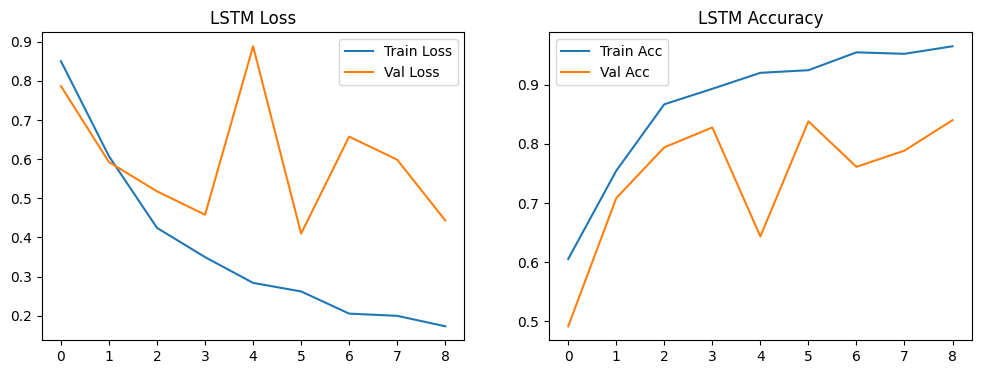

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('LSTM Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()

And yes we see that the validation loss has decreased more. But less than the training loss and the loss is higher than the one without regularization. It shows how complex it is to find the best hyperparameters for neural networks. 

### 4.5 Evaluate on Test Data

In [19]:
y_pred_lstm_prob = model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm_prob>0.5).astype(int)
print("LSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     12500
           1       0.80      0.77      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



The accuracy has decreased compared to the one without regularization. It shows the complexity of how to find the best hyperparameters and the best way to tweak neural networks.

By adding the regularization and the dropout we aimed to limit overfitting, but we see that it has not been so effective on the test set. Maybe adding more epochs or increasing the embedding dimension could help. Those would be things to try.

Also, the embedding matrix is initialized randomly. So it could be that the embedding matrix is not optimal for the task. We could try to use a **pretrained embedding matrix** (like GloVe or Word2Vec) or pre-train it ourselves on domain-specific data. This could inject more **semantic understanding** into the model and help the LSTM make better predictions.

---

## 🔧 How to Interpret Changes in Hyperparameters

When tuning a neural network like LSTM, understanding how each parameter affects the model is key. Here's a summary of what typically happens when you increase or decrease each of the main hyperparameters:

| Hyperparameter         | If You **Increase** It | If You **Decrease** It |
|------------------------|------------------------|-------------------------|
| **Batch Size**         | Faster training, but less frequent updates (less noise). Can converge faster but may get stuck in local minima. | More frequent updates (more noise), can explore better minima but training is slower and noisier. |
| **Embedding Dimension**| More capacity to represent semantic meaning. Better for complex tasks. Higher risk of overfitting. | Less capacity to capture word meaning. May underfit. |
| **LSTM Layers**        | Can model more complex patterns. Better for long-term dependencies. Slower training, more prone to overfitting. | Less expressive. May underfit complex data. |
| **Learning Rate**      | Faster convergence but may overshoot or diverge. Unstable training. | Slower, more stable training. May get stuck or take too long to converge. |
| **Epochs**             | More training time. Can help model generalize better. Risk of overfitting if too many. | Undertraining — model might not learn enough patterns. |
| **Dropout**            | Reduces overfitting. Helps generalization. If too high, model struggles to learn. | Model might overfit. Better training accuracy but worse generalization. |
| **Regularization Coefficient (L2)** | Penalizes large weights. Encourages simpler models that generalize better. | Less penalty on large weights. Can lead to overfitting if too low. |

---

## 🧪 Takeaway

Finding the best set of hyperparameters is a **balancing act**:
- Too simple? The model **underfits** — it doesn't capture important patterns.
- Too complex? The model **overfits** — it memorizes the training data but fails to generalize.

Always validate your model on a **development/test set**, and use **learning curves** (loss/accuracy over time) to help diagnose underfitting vs overfitting.

This kind of experimentation and interpretation is what makes deep learning a blend of **science and art** 🎨🔬


If we want to find the best hyperparameters for the LSTM model we can use the `keras_tuner` library.

We define the model-building function with hyperparameters and then use the `Hyperband` tuner to find the best hyperparameters.

We then use the `get_best_hyperparameters` function to get the best hyperparameters and then use the `build_model` function to build the model with the best hyperparameters.

We use the callback `EarlyStopping` to stop the training if the validation loss does not improve for 3 epochs. But even with this it will take around 1h to find the best hyperparameters.

In [25]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

# Define the model-building function with hyperparameters
def build_model(hp):
    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=64, step=16)
    lstm_units = hp.Int('lstm_units', min_value=16, max_value=64, step=16)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, step=2e-4)
    hp.Choice("batch_size", values=[32, 64, 128])
    
    inputs = keras.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(vocab_size, embedding_dim)(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", "recall", "precision"]
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='keras_tuner',
    project_name='lstm_classifier',
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True
)

# Display search space summary
tuner.search_space_summary()

def run_trial(hp, tuner, x, y, **kwargs):
    # Build the model
    model = tuner.hypermodel.build(hp)
    
    # Get batch size from hyperparameters
    batch_size = hp.get('batch_size')
    
    # Run model with the chosen batch size
    history = model.fit(
        x, y,
        batch_size=batch_size,
        **kwargs
    )
    return history

# Run the search using the run_trial function
batch_sizes = []
for trial in tuner.oracle.get_best_trials(10):
    hp = trial.hyperparameters
    batch_sizes.append(hp.get('batch_size'))
    
# Use tuner directly with custom execution
tuner.search(
    X_train_seq, y_train_lstm,
    validation_split=0.2,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')],
    batch_size=32  # This will be overridden
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best embedding dimension: {best_hps.get('embedding_dim')}")
print(f"Best LSTM units: {best_hps.get('lstm_units')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 02m 11s]
val_loss: 0.345576673746109

Best val_loss So Far: 0.33851927518844604
Total elapsed time: 00h 49m 08s


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 48)        │       960,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 96)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,009,585 (3.85 MB)

 Trainable params: 1,009,585 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

Best embedding dimension: 48
Best LSTM units: 48
Best dropout rate: 0.0
Best learning rate: 0.0005


In [26]:
y_pred_lstm = best_model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm>0.5).astype(int)
print(classification_report(y_test_lstm, y_pred_lstm))


782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [27]:
# Let's just do a quick note on each model's accuracy for a simple numeric comparison.

acc_logreg = (y_pred_logreg==y_test).mean()
acc_lstm   = (y_pred_lstm.reshape(-1)==y_test_lstm).mean()
print(f"Logistic Regression Test Accuracy: {acc_logreg:.3f}")
print(f"LSTM Test Accuracy: {acc_lstm:.3f}")

Logistic Regression Test Accuracy: 0.879
LSTM Test Accuracy: 0.825


So basically, with hyperparameter tuning we can get a better accuracy, we gained 1.5pt of accuracy. But we are still much lower than the Logistic Regression with TF-IDF that we did not even try to tune. It shows the complexity of the LSTM model. 

The most likely reason lies in the embeddings which are initialized randomly. So it must be that the embeddings are not optimal for the task. We could try to use a **pretrained embedding matrix** (like GloVe or Word2Vec) or pre-train it ourselves on domain-specific data. This could inject more **semantic understanding** into the model and help the LSTM make better predictions. We will see this in next session. 

## 5. Word-Level Interpretation in RNNs

### 5.1 Leave-One-Out Attribution for RNNs

Unlike simpler models like TF-IDF + logistic regression where each word has a fixed coefficient/weight that directly indicates its contribution to the prediction, interpreting word importance in RNNs is more challenging for several reasons:

1. **Sequential processing**: RNNs process words sequentially, so a word's impact depends on all preceding words.
2. **Hidden state complexity**: The influence of each word is captured in the hidden state, which evolves throughout the sequence.
3. **Non-linearity**: Multiple non-linear transformations make it difficult to trace a word's direct impact on the final prediction.
4. **Bidirectional influence**: In bidirectional LSTMs, a word's importance depends on both preceding and following context.

To address this challenge, we implemented a "leave-one-out" approach that:

1. Takes a complete sentence and obtains its sentiment prediction
2. Systematically removes each word one at a time
3. Observes how the prediction changes without that word
4. Words that cause large changes when removed are considered more influential

**Interpretation**:
- Words highlighted in **green** contribute positively to sentiment (removing them decreases the positive sentiment score)
- Words highlighted in **red** contribute negatively (removing them increases the positive sentiment score)
- The intensity of the color indicates the magnitude of impact

This method, while computationally more intensive than gradient-based approaches, provides more reliable interpretations for RNN architectures where gradient flow might be challenging to capture.

In [37]:
import numpy as np
from IPython.display import HTML, display

def get_word_importance_leave_one_out(model, input_text, tokenizer):
    """
    Calculate word importance by leaving each word out and measuring prediction change.
    A more reliable approach when gradient methods fail.
    """
    # Tokenize the input text
    tokens = tokenizer.texts_to_sequences([input_text])[0]
    sequence = np.array(tokens)
    
    # Create padded sequence for model input
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_len)
    
    # Get baseline prediction for full text
    baseline_prediction = model.predict(padded_sequence, verbose=0)[0][0]
    
    # Calculate impact of each word by removing it
    word_importance = []
    for i in range(len(sequence)):
        # Create a modified sequence with word i removed
        modified_sequence = sequence.copy()
        modified_sequence = np.delete(modified_sequence, i)
        
        # Pad the modified sequence
        padded_modified = tf.keras.preprocessing.sequence.pad_sequences([modified_sequence], maxlen=max_len)
        
        # Get prediction without this word
        modified_prediction = model.predict(padded_modified, verbose=0)[0][0]
        
        # Calculate importance (positive = removing word decreases sentiment)
        importance = baseline_prediction - modified_prediction
        word_importance.append(importance)
    
    # Convert token IDs back to words
    idx2word = {v: k for k, v in tokenizer.word_index.items()}
    words = [idx2word.get(token_id, '[UNK]') for token_id in sequence]
    
    return words, np.array(word_importance)

def visualize_word_importance_html(words, word_importance, threshold=0.01):
    """
    Visualize word importance using HTML with colored backgrounds.
    - Green: Positive sentiment contribution
    - Red: Negative sentiment contribution
    """
    # Normalize importance to range -1 to 1 if values are significant
    max_importance = max(abs(np.max(word_importance)), abs(np.min(word_importance)))
    if max_importance > threshold:
        normalized_importance = word_importance / max_importance
    else:
        normalized_importance = word_importance
    
    # Start HTML
    html = '<div style="font-size: 16px; line-height: 2; font-family: Arial, sans-serif; padding: 10px;">'
    
    # Show the predicted sentiment
    # Create a span for each word with color intensity based on importance
    for word, importance in zip(words, normalized_importance):
        # Calculate color intensity (0-1)
        intensity = min(abs(importance), 1.0)
        
        # Skip very low importance words (show as neutral)
        if abs(importance) < threshold:
            html += f'<span style="padding: 3px; margin: 2px; border-radius: 3px;">{word}</span> '
            continue
            
        # Determine color (red for negative, green for positive)
        if importance > 0:
            # Positive sentiment (green)
            color = f'rgba(0, 128, 0, {intensity})'
        else:
            # Negative sentiment (red)
            color = f'rgba(255, 0, 0, {intensity})'
            
        # Create span with background color
        html += f'<span style="background-color: {color}; padding: 3px; margin: 2px; border-radius: 3px;">{word}</span> '
    
    # Close HTML div
    html += '</div>'
    
    # Display HTML
    display(HTML(html))

# Example usage:
review = "The movie was terrible but the actors did a great job"
words, importances = get_word_importance_leave_one_out(best_model, review, tokenizer)
print(f"Word importances: {importances}")
visualize_word_importance_html(words, importances)

# Try another example
review = "I absolutely loved this film, it was amazing from start to finish"
words, importances = get_word_importance_leave_one_out(best_model, review, tokenizer)
visualize_word_importance_html(words, importances)

# Try a negative example
review = "This was the worst movie I have ever seen, complete waste of time"
words, importances = get_word_importance_leave_one_out(best_model, review, tokenizer)
visualize_word_importance_html(words, importances)

Word importances: [-0.00511168 -0.01023081 -0.00419638 -0.05363719  0.00032213  0.00032213
 -0.00724988 -0.01255389  0.00083612  0.04623024  0.02968016]


### 5.2 Gradient-Based Attribution for RNNs

While the leave-one-out approach provides reliable interpretations, it is computationally expensive as it requires N+1 forward passes for a sentence of N words. Here we implement a more efficient gradient-based attribution method.

#### How Input × Gradient Attribution Works:

1. **Forward Pass**: Run the input text through the model to get embeddings and predictions.
2. **Gradient Calculation**: Compute the gradient of the output (sentiment score) with respect to the word embeddings.
3. **Attribution**: Multiply these gradients by the embedding values themselves.
4. **Aggregation**: Sum across the embedding dimensions to get a single importance score per word.

This approach is based on the concept that the gradient indicates how much a small change in the embedding would affect the output, and multiplying by the embedding values weights this by the actual magnitude of the input features.

The method has several advantages:
- **Efficiency**: Requires only one forward and one backward pass
- **Directness**: Directly measures the sensitivity of the output to each word
- **Captures Interactions**: Accounts for how words interact with each other in the LSTM context

However, gradient-based methods can sometimes face challenges with vanishing gradients or saturation in deep networks, which is why we implement a fallback to the leave-one-out method. It's much more complex to implement and we will try to do in another notebook.